In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_pickle('data/micro_sud3_normalized.pkl')
df = df.reset_index()


def split_dataframe(dataframe, percent):
    nb_rows = int(np.floor(percent * len(dataframe)))
    return dataframe[:nb_rows], dataframe[nb_rows:]

def dataframe_to_xy(df):
    return (np.array(df[['PM_6182', 'PM_6179', 'PM_617B', 'PM25_6182', 'PM25_6179',\
                         'PM25_617B', 'temp', 'rh',\
                         'tgrad', 'pressure', 'pluvio']]),\
            np.array(df['PM_ref']))

        
df_train, df_test = split_dataframe(df, 0.5) 
df_valid, df_test = split_dataframe(df_test, 0.5)

X_train, y_train = dataframe_to_xy(df_train)
X_valid, y_valid = dataframe_to_xy(df_valid)
X_test, y_test = dataframe_to_xy(df_test)

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_valid= X_valid.reshape((X_valid.shape[0], 1,  X_valid.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

def dataframe_to_xy_sequences(df, sequence_size):
    out_X = np.zeros((len(df)//sequence_size, sequence_size, 8))
    out_y = np.zeros((len(df)//sequence_size, sequence_size))
    i = 0
    while i + sequence_size < len(df):
        sequence = df.iloc[i:i+sequence_size]
        out_X[i//sequence_size] =  np.array(sequence[['NO2_61FD', 'NO2_61F0', 'NO2_61EF', 'temp', 'rh',\
                                 'tgrad', 'pressure', 'pluvio']])
        out_y[i//sequence_size] = np.array(sequence['NO2_ref'])
        i += sequence_size
        
    return out_X, out_y

In [ ]:
from keras.layers import SimpleRNN, Dense, LSTM, GRU
from keras.models import Sequential
from keras.callbacks import EarlyStopping

def simple_rnn_model(nb_units, input_dim, loss='mean_squared_error', optimizer='adam'):
    model = Sequential()
    model.add(SimpleRNN(nb_units, input_shape=input_dim))#input_dim=input_dim[1], input_length=input_dim[0], return_sequences=True))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

def lstm_model(nb_units, input_dim, loss='mean_squared_error', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(nb_units, input_shape=input_dim))#input_dim=input_dim[1], input_length=input_dim[0], return_sequences=True))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

def gru_model(nb_units, input_dim, loss='mean_squared_error', optimizer='adam'):
    model = Sequential()
    model.add(GRU(nb_units, input_shape=input_dim))#input_dim=input_dim[1], input_length=input_dim[0], return_sequences=True))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

Using TensorFlow backend.


In [ ]:
model = simple_rnn_model(16, X_train.shape[1:])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 16)                448       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 465
Trainable params: 465
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto', patience=10)
history = model.fit(X_train, y_train, batch_size=16, epochs=10000, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=1, shuffle=False)

Train on 1126 samples, validate on 563 samples
Epoch 1/10000
1126/1126 [==============================] - 2s - loss: 526.2396 - val_loss: 786.6366
Epoch 2/10000
1126/1126 [==============================] - 0s - loss: 518.7957 - val_loss: 777.8568
Epoch 3/10000
1126/1126 [==============================] - 0s - loss: 508.1186 - val_loss: 764.1311
Epoch 4/10000
1126/1126 [==============================] - 0s - loss: 492.3231 - val_loss: 743.8312
Epoch 5/10000
1126/1126 [==============================] - 0s - loss: 470.2476 - val_loss: 716.1349
Epoch 6/10000
1126/1126 [==============================] - 0s - loss: 441.7299 - val_loss: 681.4267
Epoch 7/10000
1126/1126 [==============================] - 0s - loss: 408.0774 - val_loss: 641.4151
Epoch 8/10000
1126/1126 [==============================] - 0s - loss: 371.7507 - val_loss: 598.8539
Epoch 9/10000
1126/1126 [==============================] - 0s - loss: 335.4291 - val_loss: 556.3709
Epoch 10/10000
1126/1126 [===========================

/usr/local/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101227). Check your callbacks.
  % delta_t_median)


1126/1126 [==============================] - 0s - loss: 46.8626 - val_loss: 126.4264
Epoch 59/10000
1126/1126 [==============================] - 0s - loss: 46.4267 - val_loss: 125.5455
Epoch 60/10000
1126/1126 [==============================] - 0s - loss: 46.0138 - val_loss: 124.6719
Epoch 61/10000
1126/1126 [==============================] - 0s - loss: 45.6227 - val_loss: 123.8130
Epoch 62/10000
1126/1126 [==============================] - 0s - loss: 45.2530 - val_loss: 122.9744
Epoch 63/10000
1126/1126 [==============================] - 0s - loss: 44.9041 - val_loss: 122.1613
Epoch 64/10000
1126/1126 [==============================] - 0s - loss: 44.5756 - val_loss: 121.3776
Epoch 65/10000
1126/1126 [==============================] - 0s - loss: 44.2671 - val_loss: 120.6276
Epoch 66/10000
1126/1126 [==============================] - 0s - loss: 43.9778 - val_loss: 119.9141
Epoch 67/10000
1126/1126 [==============================] - 0s - loss: 43.7069 - val_loss: 119.2384
Epoch 68/10000


1126/1126 [==============================] - 0s - loss: 37.6770 - val_loss: 105.8976
Epoch 140/10000
1126/1126 [==============================] - 0s - loss: 37.6439 - val_loss: 105.8393
Epoch 141/10000
1126/1126 [==============================] - 0s - loss: 37.6114 - val_loss: 105.7830
Epoch 142/10000
1126/1126 [==============================] - 0s - loss: 37.5793 - val_loss: 105.7285
Epoch 143/10000
1126/1126 [==============================] - 0s - loss: 37.5476 - val_loss: 105.6758
Epoch 144/10000
1126/1126 [==============================] - 0s - loss: 37.5164 - val_loss: 105.6249
Epoch 145/10000
1126/1126 [==============================] - 0s - loss: 37.4854 - val_loss: 105.5756
Epoch 146/10000
1126/1126 [==============================] - 0s - loss: 37.4548 - val_loss: 105.5281
Epoch 147/10000
1126/1126 [==============================] - 0s - loss: 37.4246 - val_loss: 105.4824
Epoch 148/10000
1126/1126 [==============================] - 0s - loss: 37.3945 - val_loss: 105.4385
Epoch 

1126/1126 [==============================] - 0s - loss: 34.9339 - val_loss: 103.8811
Epoch 221/10000
1126/1126 [==============================] - 0s - loss: 34.8961 - val_loss: 103.8343
Epoch 222/10000
1126/1126 [==============================] - 0s - loss: 34.8584 - val_loss: 103.7860
Epoch 223/10000
1126/1126 [==============================] - 0s - loss: 34.8209 - val_loss: 103.7359
Epoch 224/10000
1126/1126 [==============================] - 0s - loss: 34.7835 - val_loss: 103.6843
Epoch 225/10000
1126/1126 [==============================] - 0s - loss: 34.7463 - val_loss: 103.6310
Epoch 226/10000
1126/1126 [==============================] - 0s - loss: 34.7093 - val_loss: 103.5764
Epoch 227/10000
1126/1126 [==============================] - 0s - loss: 34.6724 - val_loss: 103.5203
Epoch 228/10000
1126/1126 [==============================] - 0s - loss: 34.6356 - val_loss: 103.4627
Epoch 229/10000
1126/1126 [==============================] - 0s - loss: 34.5991 - val_loss: 103.4038
Epoch 

1126/1126 [==============================] - 0s - loss: 32.3389 - val_loss: 98.3671
Epoch 302/10000
1126/1126 [==============================] - 0s - loss: 32.3134 - val_loss: 98.3023
Epoch 303/10000
1126/1126 [==============================] - 0s - loss: 32.2881 - val_loss: 98.2376
Epoch 304/10000
1126/1126 [==============================] - 0s - loss: 32.2630 - val_loss: 98.1731
Epoch 305/10000
1126/1126 [==============================] - 0s - loss: 32.2380 - val_loss: 98.1089
Epoch 306/10000
1126/1126 [==============================] - 0s - loss: 32.2132 - val_loss: 98.0448
Epoch 307/10000
1126/1126 [==============================] - 0s - loss: 32.1885 - val_loss: 97.9810
Epoch 308/10000
1126/1126 [==============================] - 0s - loss: 32.1640 - val_loss: 97.9173
Epoch 309/10000
1126/1126 [==============================] - 0s - loss: 32.1396 - val_loss: 97.8538
Epoch 310/10000
1126/1126 [==============================] - 0s - loss: 32.1153 - val_loss: 97.7905
Epoch 311/10000


1126/1126 [==============================] - 0s - loss: 30.4857 - val_loss: 93.3844
Epoch 384/10000
1126/1126 [==============================] - 0s - loss: 30.4638 - val_loss: 93.3266
Epoch 385/10000
1126/1126 [==============================] - 0s - loss: 30.4420 - val_loss: 93.2695
Epoch 386/10000
1126/1126 [==============================] - 0s - loss: 30.4203 - val_loss: 93.2134
Epoch 387/10000
1126/1126 [==============================] - 0s - loss: 30.3988 - val_loss: 93.1584
Epoch 388/10000
1126/1126 [==============================] - 0s - loss: 30.3773 - val_loss: 93.1041
Epoch 389/10000
1126/1126 [==============================] - 0s - loss: 30.3560 - val_loss: 93.0509
Epoch 390/10000
1126/1126 [==============================] - 0s - loss: 30.3347 - val_loss: 92.9988
Epoch 391/10000
1126/1126 [==============================] - 0s - loss: 30.3135 - val_loss: 92.9478
Epoch 392/10000
1126/1126 [==============================] - 0s - loss: 30.2924 - val_loss: 92.8978
Epoch 393/10000


1126/1126 [==============================] - 0s - loss: 28.6215 - val_loss: 91.8718
Epoch 465/10000
1126/1126 [==============================] - 0s - loss: 28.6001 - val_loss: 91.8727
Epoch 00464: early stopping


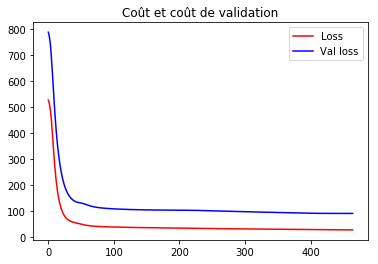

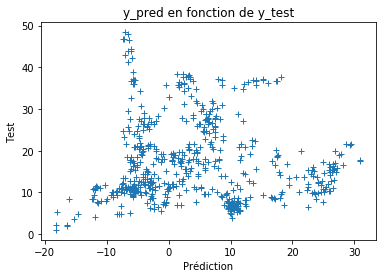

In [ ]:
y_pred = model.predict(X_test)
plt.title('Coût et coût de validation')
line1,=plt.plot(history.history['loss'], label="Loss", linestyle='-', color='r')
line2,=plt.plot(history.history['val_loss'], label="Val loss", linestyle='-', color='b')
first_legend = plt.legend(handles=[line1, line2], loc=1)

plt.show()

plt.title('y_pred en fonction de y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.ylabel('Test')
plt.xlabel('Prédiction')
plt.show()

In [ ]:
model = lstm_model(16, X_train.shape[1:])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 16)                1792      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 1,809
Trainable params: 1,809
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto', patience=10)
history = model.fit(X_train, y_train, batch_size=16, epochs=10000, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=1, shuffle=False)

Train on 1126 samples, validate on 563 samples
Epoch 1/10000
1126/1126 [==============================] - 10s - loss: 528.3325 - val_loss: 787.3433
Epoch 2/10000
1126/1126 [==============================] - 1s - loss: 523.5255 - val_loss: 780.6576
Epoch 3/10000
1126/1126 [==============================] - 1s - loss: 515.5894 - val_loss: 769.5910
Epoch 4/10000
1126/1126 [==============================] - 1s - loss: 502.5779 - val_loss: 752.6887
Epoch 5/10000
1126/1126 [==============================] - 0s - loss: 484.7943 - val_loss: 731.6394
Epoch 6/10000
1126/1126 [==============================] - 1s - loss: 464.6058 - val_loss: 708.9433
Epoch 7/10000
1126/1126 [==============================] - 1s - loss: 443.6148 - val_loss: 685.6143
Epoch 8/10000
1126/1126 [==============================] - 1s - loss: 422.5971 - val_loss: 662.0743
Epoch 9/10000
1126/1126 [==============================] - 1s - loss: 401.8339 - val_loss: 638.3226
Epoch 10/10000
1126/1126 [==========================

1126/1126 [==============================] - 0s - loss: 42.7000 - val_loss: 126.5015
Epoch 83/10000
1126/1126 [==============================] - 0s - loss: 42.5234 - val_loss: 126.0432
Epoch 84/10000
1126/1126 [==============================] - 0s - loss: 42.3519 - val_loss: 125.6026
Epoch 85/10000
1126/1126 [==============================] - 0s - loss: 42.1846 - val_loss: 125.2006
Epoch 86/10000
1126/1126 [==============================] - 0s - loss: 42.0221 - val_loss: 124.7874
Epoch 87/10000
1126/1126 [==============================] - 0s - loss: 41.8630 - val_loss: 124.3964
Epoch 88/10000
1126/1126 [==============================] - 0s - loss: 41.7094 - val_loss: 124.0195
Epoch 89/10000
1126/1126 [==============================] - 0s - loss: 41.5568 - val_loss: 123.6700
Epoch 90/10000
1126/1126 [==============================] - 0s - loss: 41.4090 - val_loss: 123.3175
Epoch 91/10000
1126/1126 [==============================] - 0s - loss: 41.2648 - val_loss: 122.9914
Epoch 92/10000


1126/1126 [==============================] - 1s - loss: 35.2338 - val_loss: 111.1563
Epoch 164/10000
1126/1126 [==============================] - 1s - loss: 35.1741 - val_loss: 111.0422
Epoch 165/10000
1126/1126 [==============================] - 1s - loss: 35.1135 - val_loss: 110.9320
Epoch 166/10000
1126/1126 [==============================] - 1s - loss: 35.0534 - val_loss: 110.8207
Epoch 167/10000
1126/1126 [==============================] - 1s - loss: 34.9925 - val_loss: 110.7089
Epoch 168/10000
1126/1126 [==============================] - 1s - loss: 34.9315 - val_loss: 110.5958
Epoch 169/10000
1126/1126 [==============================] - 1s - loss: 34.8710 - val_loss: 110.4910
Epoch 170/10000
1126/1126 [==============================] - 0s - loss: 34.8096 - val_loss: 110.3750
Epoch 171/10000
1126/1126 [==============================] - 0s - loss: 34.7492 - val_loss: 110.2716
Epoch 172/10000
1126/1126 [==============================] - 0s - loss: 34.6879 - val_loss: 110.1616
Epoch 

1126/1126 [==============================] - 1s - loss: 30.4258 - val_loss: 103.7450
Epoch 245/10000
1126/1126 [==============================] - 1s - loss: 30.3760 - val_loss: 103.7048
Epoch 246/10000
1126/1126 [==============================] - 1s - loss: 30.3249 - val_loss: 103.6727
Epoch 247/10000
1126/1126 [==============================] - 1s - loss: 30.2759 - val_loss: 103.6404
Epoch 248/10000
1126/1126 [==============================] - 1s - loss: 30.2253 - val_loss: 103.6110
Epoch 249/10000
1126/1126 [==============================] - 1s - loss: 30.1757 - val_loss: 103.5798
Epoch 250/10000
1126/1126 [==============================] - 1s - loss: 30.1260 - val_loss: 103.5583
Epoch 251/10000
1126/1126 [==============================] - 1s - loss: 30.0773 - val_loss: 103.5201
Epoch 252/10000
1126/1126 [==============================] - 1s - loss: 30.0276 - val_loss: 103.4923
Epoch 253/10000
1126/1126 [==============================] - 1s - loss: 29.9789 - val_loss: 103.4713
Epoch 

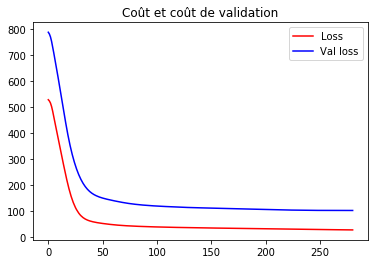

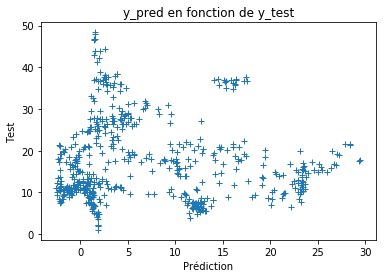

In [ ]:
y_pred = model.predict(X_test)
plt.title('Coût et coût de validation')
line1,=plt.plot(history.history['loss'], label="Loss", linestyle='-', color='r')
line2,=plt.plot(history.history['val_loss'], label="Val loss", linestyle='-', color='b')
first_legend = plt.legend(handles=[line1, line2], loc=1)

plt.show()

plt.title('y_pred en fonction de y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.ylabel('Test')
plt.xlabel('Prédiction')
plt.show()

In [ ]:
model = gru_model(16, X_train.shape[1:])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 16)                1344      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 1,361
Trainable params: 1,361
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto', patience=10)
history = model.fit(X_train, y_train, batch_size=16, epochs=10000, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=1, shuffle=False)

Train on 1126 samples, validate on 563 samples
Epoch 1/10000
1126/1126 [==============================] - 8s - loss: 528.2021 - val_loss: 786.4302
Epoch 2/10000
1126/1126 [==============================] - 0s - loss: 522.6544 - val_loss: 778.7331
Epoch 3/10000
1126/1126 [==============================] - 1s - loss: 514.1227 - val_loss: 766.5121
Epoch 4/10000
1126/1126 [==============================] - 1s - loss: 500.7380 - val_loss: 748.1349
Epoch 5/10000
1126/1126 [==============================] - 0s - loss: 481.3093 - val_loss: 722.7190
Epoch 6/10000
1126/1126 [==============================] - 0s - loss: 456.3383 - val_loss: 691.8259
Epoch 7/10000
1126/1126 [==============================] - 0s - loss: 428.2213 - val_loss: 658.4777
Epoch 8/10000
1126/1126 [==============================] - 1s - loss: 399.1722 - val_loss: 624.3142
Epoch 9/10000
1126/1126 [==============================] - 1s - loss: 370.0526 - val_loss: 589.8597
Epoch 10/10000
1126/1126 [===========================

1126/1126 [==============================] - 0s - loss: 40.4227 - val_loss: 123.8240
Epoch 83/10000
1126/1126 [==============================] - 1s - loss: 40.2939 - val_loss: 123.4678
Epoch 84/10000
1126/1126 [==============================] - 1s - loss: 40.1688 - val_loss: 123.1118
Epoch 85/10000
1126/1126 [==============================] - 1s - loss: 40.0472 - val_loss: 122.7654
Epoch 86/10000
1126/1126 [==============================] - 1s - loss: 39.9286 - val_loss: 122.4301
Epoch 87/10000
1126/1126 [==============================] - 1s - loss: 39.8137 - val_loss: 122.0979
Epoch 88/10000
1126/1126 [==============================] - 1s - loss: 39.7017 - val_loss: 121.7653
Epoch 89/10000
1126/1126 [==============================] - 1s - loss: 39.5914 - val_loss: 121.4511
Epoch 90/10000
1126/1126 [==============================] - 1s - loss: 39.4842 - val_loss: 121.1427
Epoch 91/10000
1126/1126 [==============================] - 1s - loss: 39.3787 - val_loss: 120.8281
Epoch 92/10000


1126/1126 [==============================] - 0s - loss: 34.5258 - val_loss: 110.2727
Epoch 164/10000
1126/1126 [==============================] - 1s - loss: 34.4763 - val_loss: 110.2208
Epoch 165/10000
1126/1126 [==============================] - 0s - loss: 34.4274 - val_loss: 110.1643
Epoch 166/10000
1126/1126 [==============================] - 0s - loss: 34.3776 - val_loss: 110.1255
Epoch 167/10000
1126/1126 [==============================] - 0s - loss: 34.3282 - val_loss: 110.0790
Epoch 168/10000
1126/1126 [==============================] - 0s - loss: 34.2793 - val_loss: 110.0282
Epoch 169/10000
1126/1126 [==============================] - 1s - loss: 34.2299 - val_loss: 109.9807
Epoch 170/10000
1126/1126 [==============================] - 1s - loss: 34.1806 - val_loss: 109.9347
Epoch 171/10000
1126/1126 [==============================] - 0s - loss: 34.1309 - val_loss: 109.8864
Epoch 172/10000
1126/1126 [==============================] - 1s - loss: 34.0810 - val_loss: 109.8501
Epoch 

1126/1126 [==============================] - 0s - loss: 30.3564 - val_loss: 107.4729
Epoch 245/10000
1126/1126 [==============================] - 0s - loss: 30.3071 - val_loss: 107.4582
Epoch 246/10000
1126/1126 [==============================] - 0s - loss: 30.2582 - val_loss: 107.4452
Epoch 247/10000
1126/1126 [==============================] - 0s - loss: 30.2101 - val_loss: 107.4219
Epoch 248/10000
1126/1126 [==============================] - 0s - loss: 30.1611 - val_loss: 107.4078
Epoch 249/10000
1126/1126 [==============================] - 0s - loss: 30.1134 - val_loss: 107.3820
Epoch 250/10000
1126/1126 [==============================] - 0s - loss: 30.0643 - val_loss: 107.3739
Epoch 251/10000
1126/1126 [==============================] - 0s - loss: 30.0169 - val_loss: 107.3482
Epoch 252/10000
1126/1126 [==============================] - 0s - loss: 29.9696 - val_loss: 107.3262
Epoch 253/10000
1126/1126 [==============================] - 0s - loss: 29.9225 - val_loss: 107.3122
Epoch 

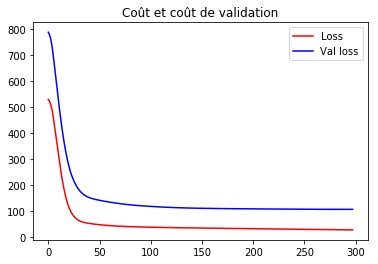

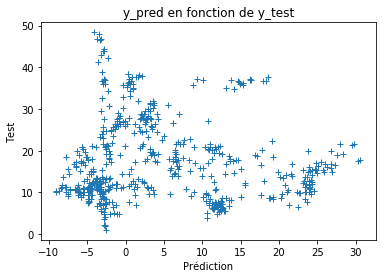

In [ ]:
y_pred = model.predict(X_test)
plt.title('Coût et coût de validation')
line1,=plt.plot(history.history['loss'], label="Loss", linestyle='-', color='r')
line2,=plt.plot(history.history['val_loss'], label="Val loss", linestyle='-', color='b')
first_legend = plt.legend(handles=[line1, line2], loc=1)

plt.show()

plt.title('y_pred en fonction de y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.ylabel('Test')
plt.xlabel('Prédiction')
plt.show()